[link text](https://)

Pediatric Pneumonia Image Classification with Deep Learning

Business Problem

In this project, the aim is to to build a deep neural network that trains on a large dataset for classification. In this case, we are using x-ray images of pediatric patients to identify whether or not they have pneumonia. The dataset comes from Kermany et al. on Mendeley.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow.random as tfr
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Chart
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import glob
from skimage import color, exposure
from sklearn.metrics import classification_report
import os
import cv2
%matplotlib inline
np.random.seed(0) 
tfr.set_seed(0)

from google.colab import drive
drive.mount('/content/drive/')

ValueError: ignored

In [ ]:

data_path = '/content/drive/My Drive/Kaggle/chest_xray'


train_path = data_path + '/train/'
test_path = data_path + '/test/'
val_path = data_path + '/val/'


Resizing the images to a workable size

In [ ]:
img_size = 200

This function assists in reading the image data from the folders and returns a numpy array with [img,label]

In [ ]:
def read_data(data_paths):
    for data_path in data_paths:
        labels = ['PNEUMONIA', 'NORMAL']
        images = []
        y = []
        for label in labels:
            curr_path = data_path + label
            for img in os.listdir(curr_path):
                if ('DS' not in img):
                    image_path = os.path.join(curr_path, img)
                    image =  cv2.resize(cv2.imread(image_path), (img_size, img_size))
                    if image is not None:
                        images.append([image, label])
                
    images = np.asarray(images)
    return images

Set the dataset for our test and train folders

In [ ]:
train = read_data([train_path])
test = read_data([val_path, test_path])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Shuffling the data to create randomness in batches

In [8]:
for i in range(10):
    np.random.shuffle(train)
    np.random.shuffle(test)

Creating dataframes to assist with visualization

In [9]:
train_df = pd.DataFrame(train, columns=['image', 'label'])
test_df = pd.DataFrame(test, columns = ['image', 'label'])

In [10]:
train_df['label'].head()

0    PNEUMONIA
1    PNEUMONIA
2       NORMAL
3    PNEUMONIA
4    PNEUMONIA
Name: label, dtype: object

**Eploratory Data Analysis**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


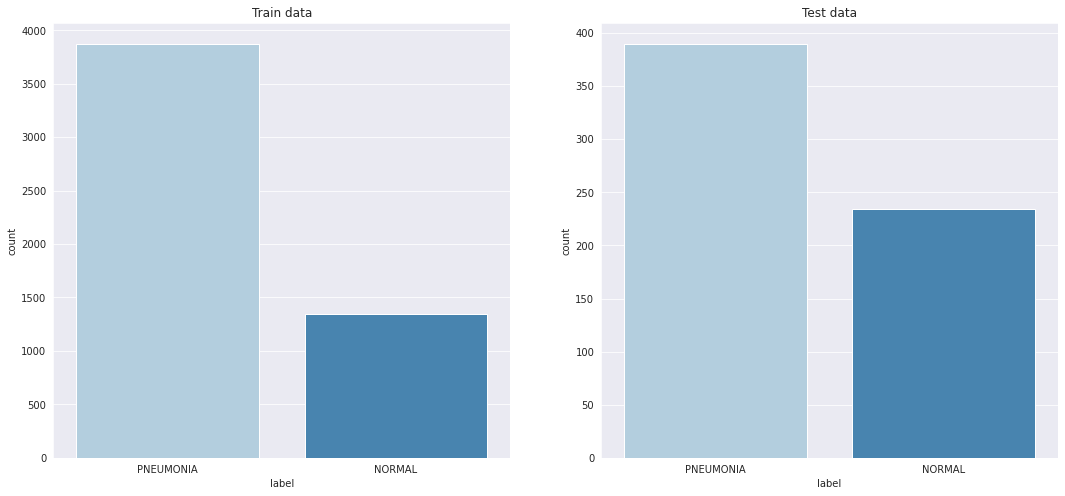

In [11]:
plt.figure(figsize=(18, 8))
sns.set_style("darkgrid")

plt.subplot(1,2,1)
sns.countplot(train_df['label'], palette = 'Blues')
plt.title('Train data')

plt.subplot(1,2,2)
sns.countplot(test_df['label'], palette = "Blues")
plt.title('Test data')

plt.show()

Previewing Images

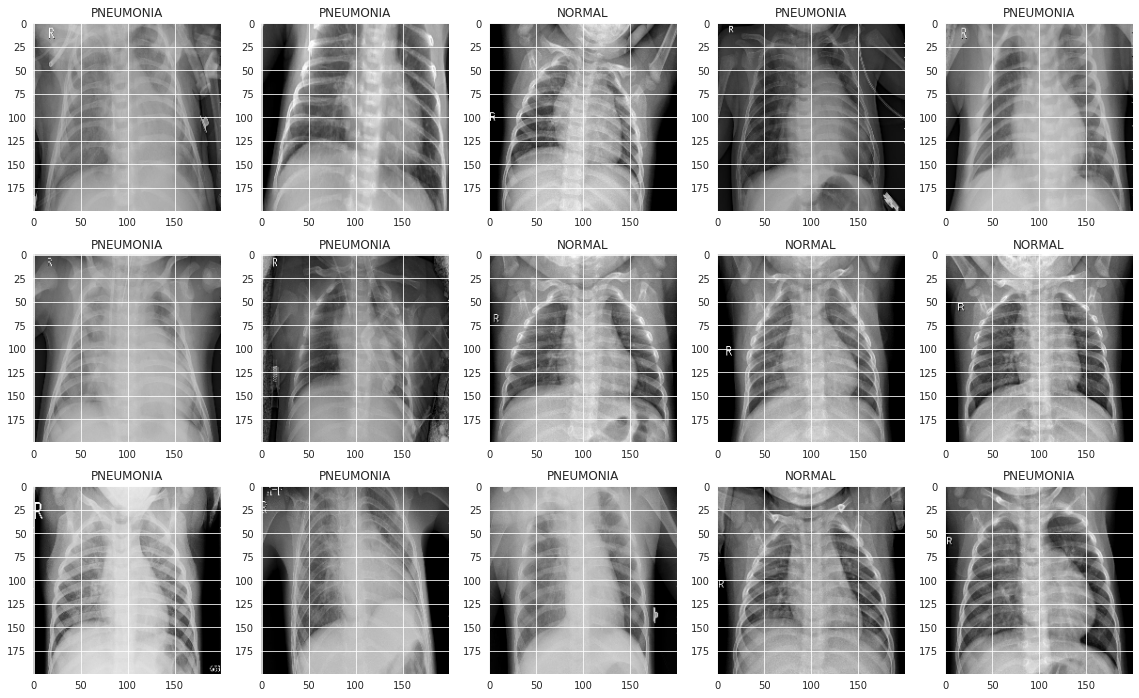

In [12]:
def Show_example_image():
    fig = plt.figure(figsize = (16, 16))
    for idx in range(15):
        plt.subplot(5, 5, idx+1)
        plt.imshow(train_df.iloc[idx]['image'])
        plt.title("{}".format(train_df.iloc[idx]['label']))
        
    plt.tight_layout()
    
Show_example_image()

**Data Preprocessing**

In [13]:
def lung_condition(label):
    if label == 'NORMAL':
        return 0
    else:
        return 1

Function that will allow us to split the datasets into arrays of X and y

In [14]:
def splitdata(data):
    X = []
    y = []
    for i, (val, label) in enumerate(data):
        X.append(val)
        y.append(lung_condition(label))
    return np.array(X), np.array(y)


Splitting our data

In [15]:
np.random.shuffle(train)
np.random.shuffle(test)
X_train, y_train = splitdata(train)
X_test, y_test = splitdata(test)

Grayscale conversion, normalization and table reshaping function for multilayer perceptron

In [16]:
def preprocesing_to_mlp(data):
    data1 = color.rgb2gray(data).reshape(-1, img_size * img_size).astype('float32')
    
    # Data Normalization [0, 1]
    data1 /= 255
    
    return data1

In [17]:
X_train = preprocesing_to_mlp(X_train)
X_test = preprocesing_to_mlp(X_test)

In [18]:
num_pixels = X_train.shape[1] 

# one-hot encoding for target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_train.shape[1]

Function for drawing learning curve histry of the neural network

In [19]:
def draw_learning_curve(history, keys=['accuracy', 'loss']):
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x = history.epoch, y = history.history[key])
        sns.lineplot(x = history.epoch, y = history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
#         plt.ylim(ylim)
        plt.legend(['train', 'test'], loc='best')
    plt.show()

Creating our MLP

Callbacks 

* EarlyStopping (Stop training when a monitored metric has stopped improving)

* ReduceLROnPlateau (Reduce learning rate when a metric has stopped improving)




In [20]:
callbacks1 = [ 
    EarlyStopping(monitor = 'loss', patience = 6), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
]

First Model

In [21]:
def get_mlp():
    
    return Sequential([
        #input layer is automatic generation by keras
        
        #hidden layer
        Dense(1024, input_dim = num_pixels, activation='relu'),
        
        #output layer
        Dense(num_classes, activation='softmax')
    ])

In [22]:
model = get_mlp()
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              40961024  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 40,963,074
Trainable params: 40,963,074
Non-trainable params: 0
_________________________________________________________________


Fitting the model

In [23]:
learning_history = model.fit(X_train, y_train,
          batch_size = 64, epochs = 40, verbose = 2,
          callbacks = callbacks1,
          validation_data=(X_test, y_test));

Epoch 1/40
82/82 - 4s - loss: 0.3952 - accuracy: 0.8206 - val_loss: 0.5106 - val_accuracy: 0.7420
Epoch 2/40
82/82 - 1s - loss: 0.2028 - accuracy: 0.9199 - val_loss: 0.5654 - val_accuracy: 0.7500
Epoch 3/40
82/82 - 1s - loss: 0.1679 - accuracy: 0.9335 - val_loss: 0.5621 - val_accuracy: 0.7644
Epoch 4/40
82/82 - 1s - loss: 0.1493 - accuracy: 0.9388 - val_loss: 0.5669 - val_accuracy: 0.7740
Epoch 5/40
82/82 - 1s - loss: 0.1202 - accuracy: 0.9548 - val_loss: 0.6071 - val_accuracy: 0.7740
Epoch 6/40
82/82 - 1s - loss: 0.1218 - accuracy: 0.9546 - val_loss: 0.6033 - val_accuracy: 0.7821
Epoch 7/40
82/82 - 1s - loss: 0.1166 - accuracy: 0.9559 - val_loss: 1.0503 - val_accuracy: 0.7131
Epoch 8/40
82/82 - 1s - loss: 0.1167 - accuracy: 0.9540 - val_loss: 0.5741 - val_accuracy: 0.7901
Epoch 9/40
82/82 - 1s - loss: 0.1074 - accuracy: 0.9576 - val_loss: 0.9723 - val_accuracy: 0.7260
Epoch 10/40
82/82 - 1s - loss: 0.1038 - accuracy: 0.9615 - val_loss: 0.8684 - val_accuracy: 0.7404
Epoch 11/40
82/82 -

Evaluation

In [24]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 106.46991729736328%
Test accuracy: 73.23718070983887%
MLP Error: 26.76%


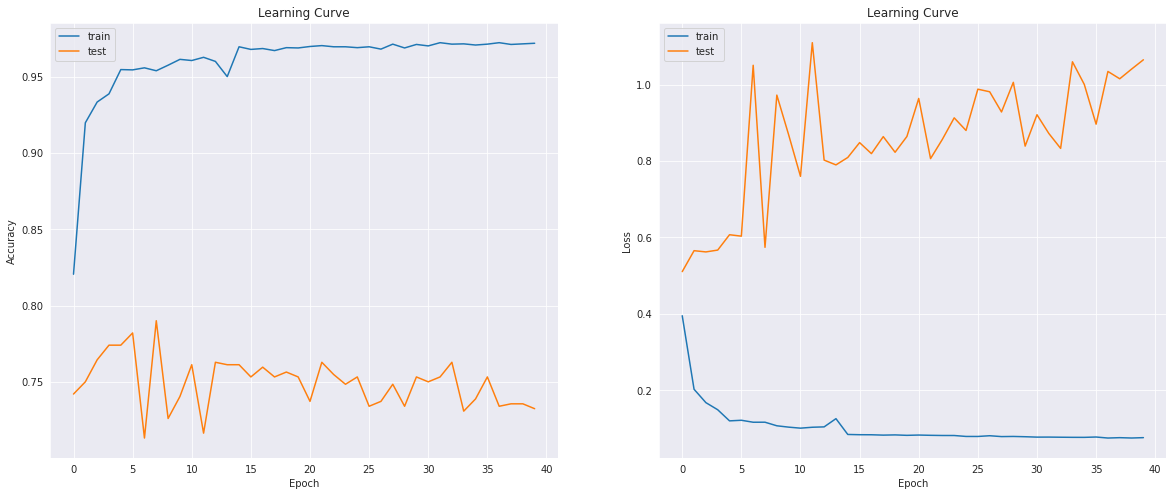

In [25]:
draw_learning_curve(learning_history)

Second Model

In [26]:
callbacks2 = [ 
    EarlyStopping(monitor = 'loss', patience = 6), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
]

In [27]:
def get_mlpv2():
    
    return Sequential([
        Dense(1024, input_dim=num_pixels, activation='relu'),
        Dropout(0.4),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

In [28]:
model = get_mlpv2()
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1024)              40961024  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

Fitting the second model

In [29]:
learning_history = model.fit(X_train, y_train,
          batch_size = 64, epochs = 100, verbose = 1,
          callbacks = callbacks2,
          validation_data=(X_test, y_test));

Epoch 1/100
82/82 [==============================] - 2s 14ms/step - loss: 0.5355 - accuracy: 0.7414 - val_loss: 0.6902 - val_accuracy: 0.7212
Epoch 2/100
82/82 [==============================] - 1s 12ms/step - loss: 0.2228 - accuracy: 0.9150 - val_loss: 0.7207 - val_accuracy: 0.7612
Epoch 3/100
82/82 [==============================] - 1s 13ms/step - loss: 0.2138 - accuracy: 0.9129 - val_loss: 0.3647 - val_accuracy: 0.8301
Epoch 4/100
82/82 [==============================] - 1s 12ms/step - loss: 0.1961 - accuracy: 0.9152 - val_loss: 0.4394 - val_accuracy: 0.8157
Epoch 5/100
82/82 [==============================] - 1s 13ms/step - loss: 0.1554 - accuracy: 0.9427 - val_loss: 0.6155 - val_accuracy: 0.7772
Epoch 6/100
82/82 [==============================] - 1s 13ms/step - loss: 0.1575 - accuracy: 0.9428 - val_loss: 0.5827 - val_accuracy: 0.7676
Epoch 7/100
82/82 [==============================] - 1s 12ms/step - loss: 0.1527 - accuracy: 0.9362 - val_loss: 1.2034 - val_accuracy: 0.6811
Epoch 

Evaluating the second model

In [30]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 85.61019897460938%
Test accuracy: 75.96153616905212%
MLP Error: 24.04%


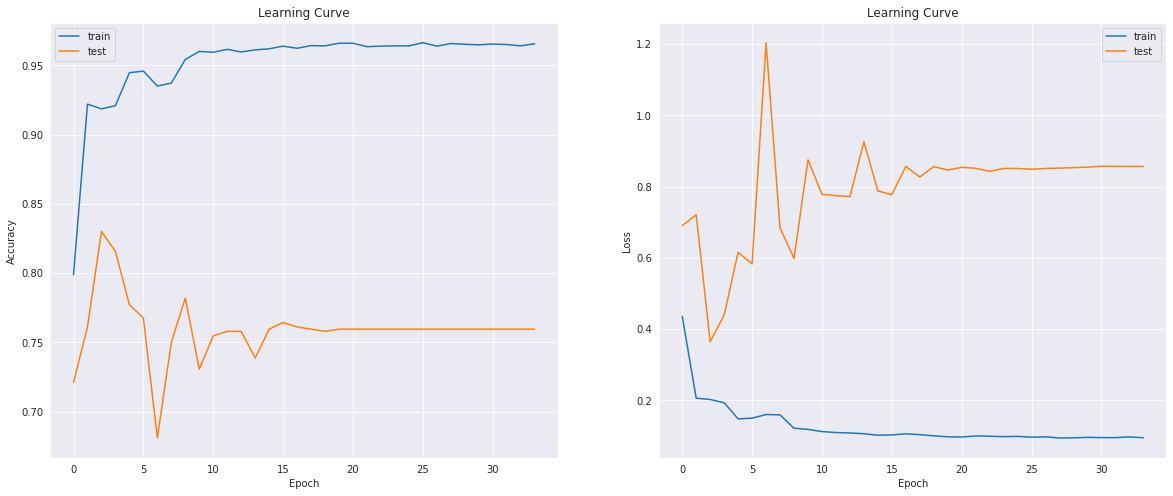

In [31]:
draw_learning_curve(learning_history)

CNN

* Simple sequential model is used, starting with 5 double convolutional networks of kernel size (3, 3) and max pooling with pool size (2, 2).

* Additionally has batch normalization and dropout

CNN Data Processing

In [32]:
X_train, y_train = splitdata(train)
X_test, y_test = splitdata(test)

Normalization, grayscale conversion and table reshaping function for CNN

In [33]:
def preprocesing_to_cnn(data):
    data1 = color.rgb2gray(data).reshape(-1, img_size, img_size, 1).astype('float32')
    data1 /= 255
    return data1

In [34]:
X_train = preprocesing_to_cnn(X_train)
X_test = preprocesing_to_cnn(X_test)

# one-hot encoding for target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [35]:
num_classes = y_train.shape[1]

In [36]:
input_shape = (img_size, img_size, 1)


In [37]:
callbacks3 = [ 
    EarlyStopping(monitor = 'loss', patience = 6), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
    ModelCheckpoint('../working/model.best3.hdf5', monitor='loss' , save_best_only=True) # saving the best model
]

In [38]:
num_pixels 

40000

CNN Model 1

In [39]:
def get_modelcnn():
    return Sequential([
        
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        
        Flatten(),
        
        Dense(512, activation='relu'),
        Dropout(0.5),
        
        Dense(256, activation='relu'),
        Dropout(0.5),
        
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation = "softmax")
        
    ])

In [40]:
model = get_modelcnn()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 16)      2320      
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 100, 32)     

Fitting 1st CNN Model


In [41]:
learning_history = model.fit(X_train, y_train,
          batch_size = 64,
          epochs = 100,
          verbose = 1,
          callbacks = callbacks3,
          validation_data = (X_test, y_test))

Epoch 1/100
82/82 [==============================] - 37s 92ms/step - loss: 1.6649 - accuracy: 0.6718 - val_loss: 1.6317 - val_accuracy: 0.6250
Epoch 2/100
82/82 [==============================] - 6s 77ms/step - loss: 0.4230 - accuracy: 0.8354 - val_loss: 5.8641 - val_accuracy: 0.6250
Epoch 3/100
82/82 [==============================] - 6s 77ms/step - loss: 0.2336 - accuracy: 0.9098 - val_loss: 7.3550 - val_accuracy: 0.6250
Epoch 4/100
82/82 [==============================] - 6s 77ms/step - loss: 0.1719 - accuracy: 0.9380 - val_loss: 6.3051 - val_accuracy: 0.6250
Epoch 5/100
82/82 [==============================] - 6s 77ms/step - loss: 0.1521 - accuracy: 0.9451 - val_loss: 7.9813 - val_accuracy: 0.6250
Epoch 6/100
82/82 [==============================] - 6s 77ms/step - loss: 0.1496 - accuracy: 0.9432 - val_loss: 8.7196 - val_accuracy: 0.6250
Epoch 7/100
82/82 [==============================] - 6s 76ms/step - loss: 0.1167 - accuracy: 0.9574 - val_loss: 4.2145 - val_accuracy: 0.6250
Epoch

Evaluation for 1st CNN Model

In [42]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 275.0560522079468%
Test accuracy: 75.4807710647583%
MLP Error: 24.52%


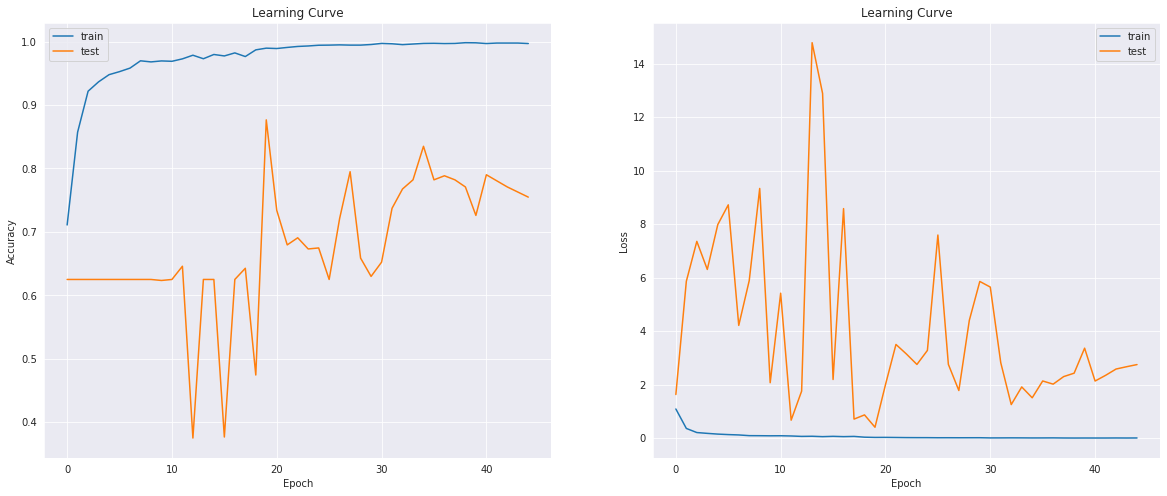

In [43]:
draw_learning_curve(learning_history)

**Data Augmentation**

* Randomly shift images horizontally by 10% of the width

* Randomly shift images vertically by 10% of the height

* Randomly rotate images by 10 degrees

* *Randomly* Zoom by 10% some images

In [44]:
datagen = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False, 
        samplewise_std_normalization = False,
        zca_whitening = False,
        horizontal_flip = False,
        vertical_flip = False,
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size = 32)

In [45]:
callbacks4 = [ 
    EarlyStopping(monitor = 'loss', patience = 7), 
    ReduceLROnPlateau(monitor = 'loss', patience = 4), 
    ModelCheckpoint('../working/model.best4.hdf5', monitor='loss' , save_best_only=True) # saving the best model
]

2nd CNN Model


In [46]:
def get_modelcnn_v2():
    return Sequential([
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Flatten(),

        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(num_classes, activation = "softmax")
        
    ])
       

In [47]:
model = get_modelcnn_v2()
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 200, 200, 16)      160       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 200, 200, 16)      2320      
_________________________________________________________________
batch_normalization_5 (Batch (None, 200, 200, 16)      64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 100, 100, 32)      4640      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 100, 100, 32)     

Fitting 2nd CNN Model

In [48]:
learning_history = model.fit_generator((train_gen), 
                               epochs = 100, 
                               steps_per_epoch = X_train.shape[0] // 32,
                               validation_data = (X_test, y_test),
                               callbacks = callbacks4,
                        )

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


163/163 [==============================] - 17s 91ms/step - loss: 0.6750 - accuracy: 0.6736 - val_loss: 1.6489 - val_accuracy: 0.6250
Epoch 2/100
163/163 [==============================] - 15s 90ms/step - loss: 0.2997 - accuracy: 0.8867 - val_loss: 0.9332 - val_accuracy: 0.6250
Epoch 3/100
163/163 [==============================] - 15s 90ms/step - loss: 0.2367 - accuracy: 0.9171 - val_loss: 1.9723 - val_accuracy: 0.6250
Epoch 4/100
163/163 [==============================] - 15s 90ms/step - loss: 0.2268 - accuracy: 0.9115 - val_loss: 2.1162 - val_accuracy: 0.6250
Epoch 5/100
163/163 [==============================] - 15s 90ms/step - loss: 0.1968 - accuracy: 0.9221 - val_loss: 3.4503 - val_accuracy: 0.6250
Epoch 6/100
163/163 [==============================] - 15s 90ms/step - loss: 0.1552 - accuracy: 0.9379 - val_loss: 0.6515 - val_accuracy: 0.6571
Epoch 7/100
163/163 [==============================] - 15s 90ms/step - loss: 0.1606 - accuracy: 0.9393 - val_loss: 4.8010 - val_accuracy: 0.62

Evaluating 2nd CNN Model

In [49]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 34.53320860862732%
Test accuracy: 91.66666865348816%
MLP Error: 8.33%


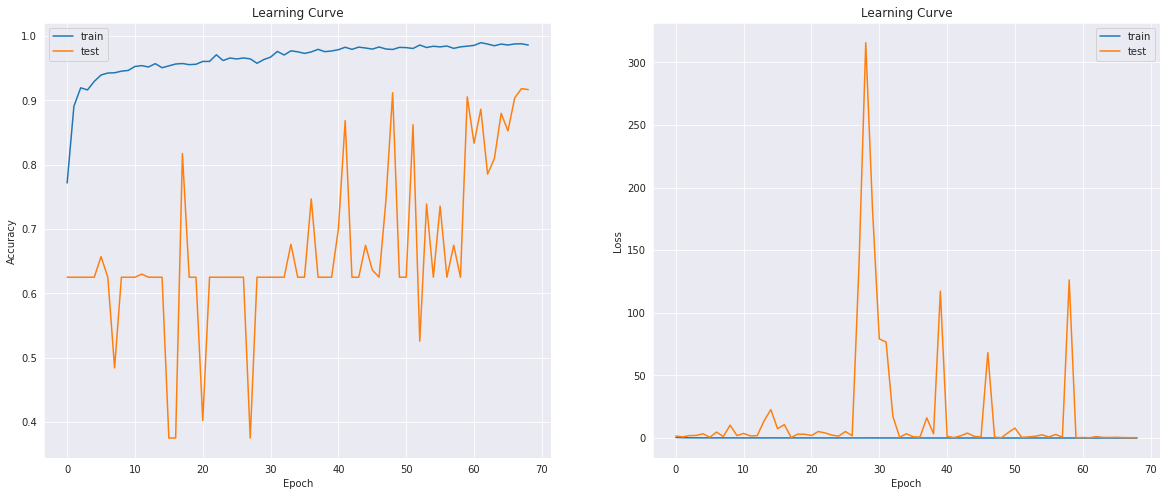

In [50]:
draw_learning_curve(learning_history)

Model Check 

In [51]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)

In [55]:
y_pre_test = np.argmax(y_test, axis = 1)

In [56]:
def show_condition(num):
    if num == 0:
        return 'NORMAL'
    return 'PNEUMONIA'

Error Amount for Labels

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


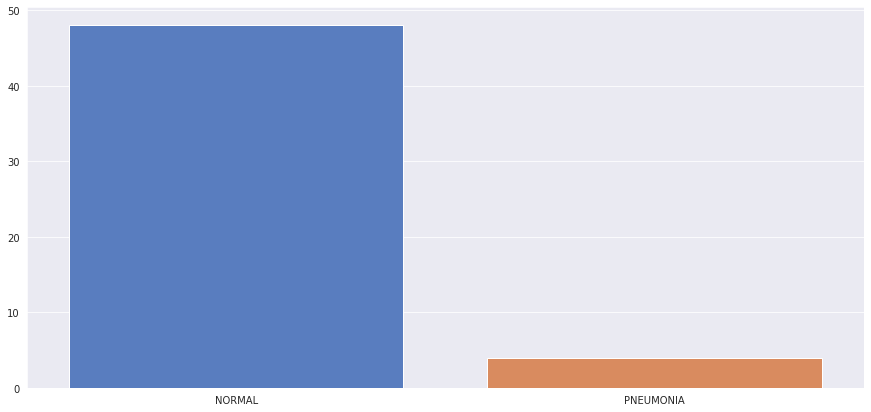

In [57]:
cnt_error = []
for idx, (a, b) in enumerate(zip(y_pre_test, y_pred)):
    if a == b: continue
    cnt_error.append(a)# test

cnt_error = np.unique(cnt_error, return_counts = True)
sns.set_style("darkgrid")
plt.figure(figsize = (15, 7))
sns.barplot([show_condition(x) for x in cnt_error[0]], cnt_error[1], palette="muted")
plt.show()

Image Check

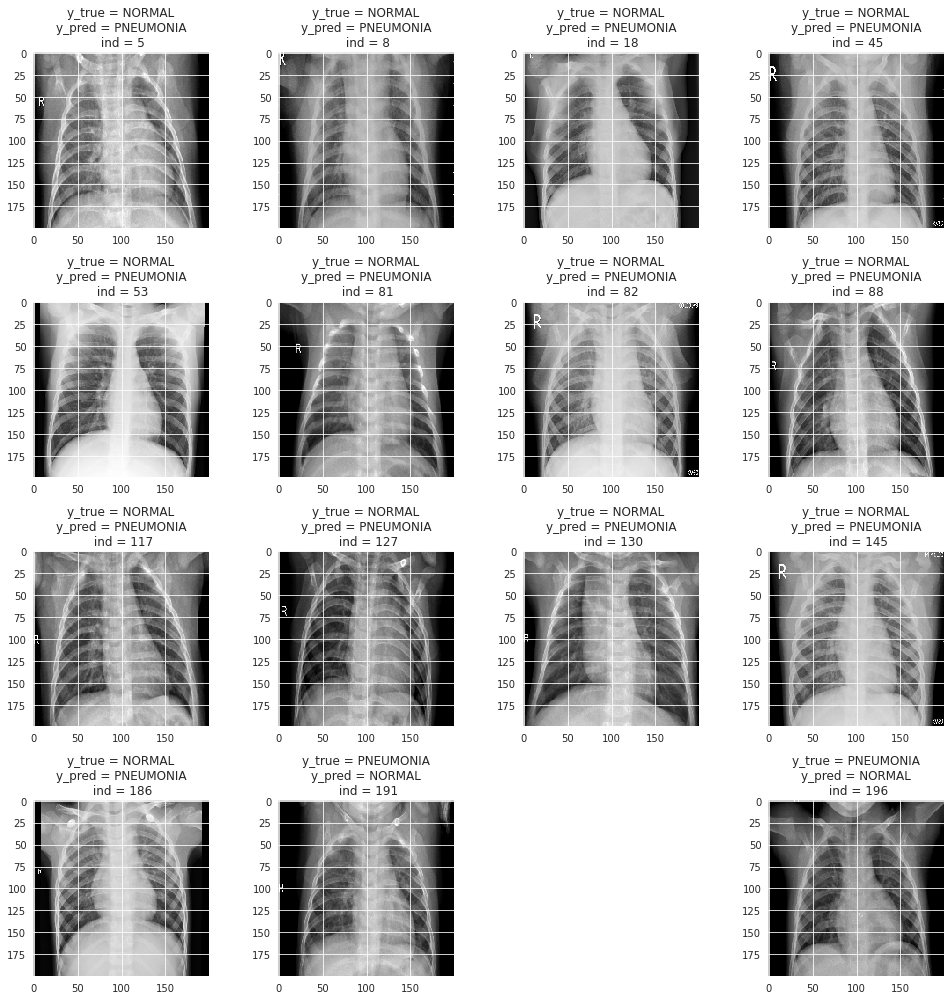

In [58]:
cnt_ind = 1
list_idx = []
fig = plt.figure(figsize=(14, 14))
X_test_plot = X_test.reshape(-1, img_size, img_size)
for idx, (a, b) in enumerate(zip(y_pre_test, y_pred)):
    if(cnt_ind > 16):break
    if a == b: continue
    plt.subplot(4, 4, cnt_ind)
    plt.imshow(X_test_plot[idx], cmap='gray', interpolation='none')
    plt.title('y_true = {0}\ny_pred = {1}\n ind = {2}'.format(show_condition(a), show_condition(b), idx))
    plt.tight_layout()
    list_idx.append(idx)
    cnt_ind += 1


**Conclusion**

*Our model has 91.6% accuracy and has some error of approximately 8.33%. This means that there were some instances when the patient had pneumonia but was diagnosed as healthy. It was helpful to grayscale and limit the epochs by using early stopping to prevent overfitting of the model.




**Future Work**

It is important to consider that there may be a potential for human error as well, which would be seen as a misdiagnosis. Work with cross-validating with a team of radiologist and/or pulmonologist would be helpful in making sure that our images where labeled correctly.

Future work would benefit from utilizing more data from populations such as adults and the elderly as well as from different parts of the world. This would allow us to generalize the data and increase the accuracy of diagnosis.

This model may be helpful as a primary screening test for patients. Since it has usable accuracy, this could flag a physician to examine the models determination and make the final confirmatory call on the diagnosis. 

In [60]:
print(classification_report(y_pre_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.79      0.88       234
           1       0.89      0.99      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.89      0.91       624
weighted avg       0.92      0.92      0.91       624

